# Features Selection MonoVariate

In [1]:
% matplotlib inline

import pickle
import time

import pandas as pd

from IPython import display as d
# from IPython import 

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn import feature_selection as fs
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn import preprocessing as prp
import sklearn

from joblib import Parallel, cpu_count, delayed

from libs import container
from libs.experiment import (
    WithAnotherExperiment, KFoldExperiment, roc, 
    discretize_classes, clean_features)

%load_ext ipycache

/home/jbcabral/.conda/envs/carpyncho3/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/home/jbcabral/.conda/envs/carpyncho3/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


## 1. Load Data

In [2]:
start = time.time()

df = pd.read_pickle("data/normalized2500.pkl")

scaler = {k: (v0, v1) for k,v0,v1 in pickle.load(open("data/scaler.pkl"))}

##  2. Preprocess

### 2.1. Discretize the classes

In [3]:
def corrector(row):
    o3t = (row.ogle3_type or "").split("-", 1)[0]
    scls = row.scls
    return o3t, scls

classes = dict(set(map(tuple, df[["ogle3_type", "cls"]].values)))    
sclasses = dict(set(map(tuple, df[["ogle3_type", "scls"]].apply(corrector, axis=1).values)))
tclasses = {k: v for v, k in enumerate(df.tcls.unique())}

def to_tcls(row):
    tcls = str(row.tcls)
    return tclasses[tcls]

df.tcls = df.apply(to_tcls, axis=1)

d.display(d.Markdown("**Classes**"))
d.display(classes)

d.display(d.Markdown("----"))
d.display(d.Markdown("**Simplified Classes**"))
d.display(sclasses)

d.display(d.Markdown("----"))
d.display(d.Markdown("**Tile Classes**"))
d.display(tclasses)

**Classes**

{'': 0,
 'Cep-1': 1,
 'Cep-F': 2,
 'LPV-OSARG': 4,
 'LPV-SRV': 5,
 'RRLyr-RRab': 6,
 'RRLyr-RRc': 7,
 'RRLyr-RRd': 8,
 'T2Cep-BLHer': 9}

----

**Simplified Classes**

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

----

**Tile Classes**

{'b261': 2, 'b262': 0, 'b263': 1, 'b264': 4, 'b278': 3}

### 2.2. Removes all low-variance and "bad" features

In [4]:
X_columns = clean_features({"df": df}, "df")
# X_columns = X_columns.drop("AndersonDarling")
X_columns = X_columns[~(X_columns.str.startswith("Freq2_") | X_columns.str.startswith("Freq3_"))]
print("Total features:", X_columns.size)

Removing [] because null
Removing [] because lowvariance
('Total features:', 55)


### 2.3. Selected features

In [5]:
X_columns

Index([u'cnt', u'Amplitude', u'Autocor_length', u'Beyond1Std', u'CAR_mean',
       u'CAR_sigma', u'CAR_tau', u'Con', u'Eta_e', u'FluxPercentileRatioMid20',
       u'FluxPercentileRatioMid35', u'FluxPercentileRatioMid50',
       u'FluxPercentileRatioMid65', u'FluxPercentileRatioMid80',
       u'Freq1_harmonics_amplitude_0', u'Freq1_harmonics_amplitude_1',
       u'Freq1_harmonics_amplitude_2', u'Freq1_harmonics_amplitude_3',
       u'Freq1_harmonics_rel_phase_1', u'Freq1_harmonics_rel_phase_2',
       u'Freq1_harmonics_rel_phase_3', u'LinearTrend', u'MaxSlope', u'Mean',
       u'Meanvariance', u'MedianAbsDev', u'MedianBRP', u'PairSlopeTrend',
       u'PercentAmplitude', u'PercentDifferenceFluxPercentile', u'PeriodLS',
       u'Psi_CS', u'Psi_eta', u'Q31', u'Rcs', u'Skew', u'SmallKurtosis',
       u'Std', u'c89_jk_color', u'c89_hk_color', u'c89_jh_color',
       u'n09_jk_color', u'n09_hk_color', u'n09_jh_color', u'c89_m2', u'c89_m4',
       u'c89_c3', u'n09_m2', u'n09_m4', u'n09_c3', u'A

In [6]:
sclasses

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

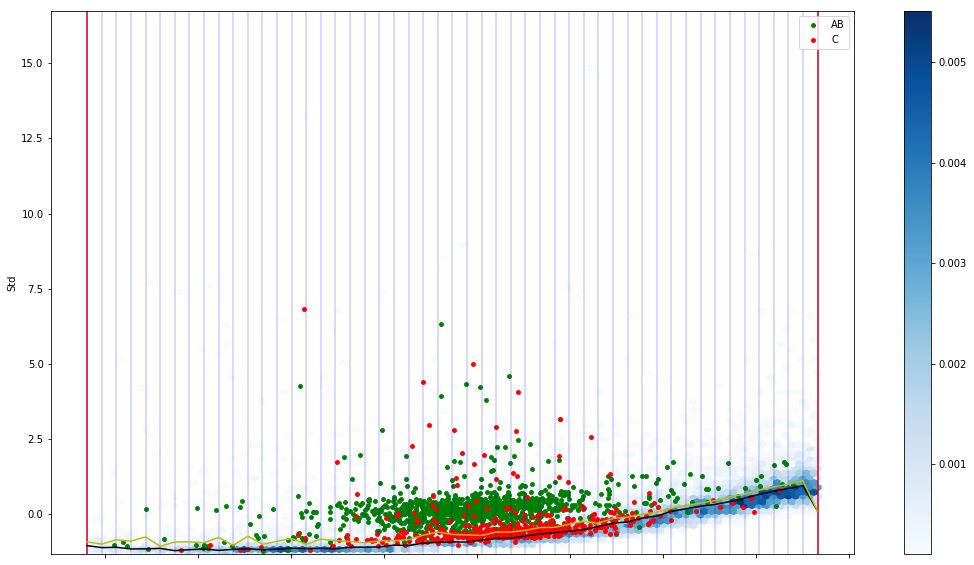

In [7]:
import numpy as np
flt = (12 - scaler["Mean"][0]) / scaler["Mean"][1], (16.5 - scaler["Mean"][0]) / scaler["Mean"][1]

def plot(data):
    all_df = data
    size = len(all_df)

    all_df['C'] = pd.Series(np.ones(size), index=all_df.index)

    unk = all_df[all_df.cls == 0]
    unk_size = len(unk)

    ax = unk.plot.hexbin(
        "Mean", "Std", cmap="Blues", C="C", 
        reduce_C_function=lambda x: (np.sum(x) / unk_size),
        figsize=(18, 10))

    all_df[all_df.cls == 6].plot.scatter("Mean", "Std", s=15, color="g", ax=ax, label="AB")
    all_df[all_df.cls == 7].plot.scatter("Mean", "Std", s=15, color="r", ax=ax, label="C")

    for limit in flt:
        ax.axvline(limit, color="r")


    bins = np.histogram(unk.Mean, bins=50)[1]

    unk = unk.assign(bins=unk.Mean.apply(np.digitize, bins=bins))

    for idx in bins:
        ax.axvline(idx, color="b", alpha=.2)

    plt.plot(bins, unk.groupby("bins")["Std"].median(), "k")
    plt.plot(bins, unk.groupby("bins")["Std"].mean(), "y")

    return ax
    
plot(df)

In [8]:
tile_unk = df.groupby("tcls").apply(lambda x: x[x.scls==0].sample(500))

min_size = df[df.scls == 3].groupby("tcls").size().min()
tile_balanced = df.groupby("tcls").apply(lambda x: x[x.scls==3].sample(min_size))

tile_mix = pd.concat([tile_balanced, tile_unk])

In [9]:
def experiment(clf, x_train, y_train, x_test, y_test, pos_label):
    clf = sklearn.clone(clf)
    clf.fit(x_train, y_train)

    predictions = clf.predict(x_test)
    probabilities = clf.predict_proba(x_test)

    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 1.-probabilities[:,0], pos_label=pos_label)
    prec_rec_curve = metrics.precision_recall_curve(
        y_test, 1.- probabilities[:,0], pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)

    return container.Container({
            'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'prec_rec_curve': prec_rec_curve,
            'y_test': y_test, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_test, predictions)})


# kfold
def kfolds(data, X_columns, y_column, clf, nfolds, verbose=True):
    skf = StratifiedKFold(n_splits=nfolds)

    subject_df = data

    x = subject_df[X_columns].values
    y = subject_df[y_column].values
    y_real = subject_df[y_column].values

    probabilities = None
    predictions = np.array([])
    y_testing = np.array([])
    y_testing_real = np.array([])

    for train, test in skf.split(x, y):
        x_train = x[train]
        y_train = y[train]
        x_test = x[test]
        y_test = y[test]
        y_test_real = y_real[test]

        rst = experiment(clf, x_train, y_train, x_test, y_test, pos_label=0)            
        
        probabilities = (
            rst.probabilities if probabilities is None else
            np.vstack([probabilities, rst.probabilities]))
        predictions = np.hstack([predictions, rst.predictions])
        y_testing = np.hstack([y_testing, y_test])
        y_testing_real = np.hstack([y_testing_real, y_test_real])
        del rst

    fpr, tpr, thresholds = metrics.roc_curve(
        y_testing, 1.-probabilities[:,0], pos_label=0)
    prec_rec_curve = metrics.precision_recall_curve(
        y_testing, 1.- probabilities[:,0], pos_label=0)
    roc_auc = metrics.auc(fpr, tpr)
    
    if verbose:
        print metrics.classification_report(y_testing, predictions)
        print "-" * 80

    return container.Container({
        'fpr': fpr, 
        'tpr': tpr, 
        'thresh': thresholds, 
        'roc_auc': roc_auc, 
        'prec_rec_curve': prec_rec_curve,
        'y_test': y_testing, 
        'y_test_real': y_testing_real,
        'predictions': predictions,
        'probabilities': probabilities, 
        'confusion_matrix': metrics.confusion_matrix(y_testing, predictions)})

In [10]:
%%time
clf = SVC(kernel='poly', probability=True)
kfolds(tile_balanced, X_columns, y_column="tcls", clf=clf, nfolds=10)

             precision    recall  f1-score   support

        0.0       0.25      0.14      0.18       220
        1.0       0.32      0.20      0.25       220
        2.0       0.35      0.21      0.26       220
        3.0       0.25      0.73      0.38       220
        4.0       0.31      0.12      0.17       220

avg / total       0.30      0.28      0.25      1100

--------------------------------------------------------------------------------
CPU times: user 12 s, sys: 1 ms, total: 12 s
Wall time: 12 s


In [11]:
%%time
clf = SVC(kernel='poly', probability=True)
kfolds(tile_unk, X_columns, y_column="tcls", clf=clf, nfolds=10)

             precision    recall  f1-score   support

        0.0       0.24      0.71      0.35       500
        1.0       0.36      0.35      0.35       500
        2.0       0.30      0.17      0.21       500
        3.0       0.53      0.13      0.21       500
        4.0       0.40      0.10      0.16       500

avg / total       0.37      0.29      0.26      2500

--------------------------------------------------------------------------------
CPU times: user 1min, sys: 3 ms, total: 1min
Wall time: 1min


In [12]:
print "\n".join(["{} - {}".format(v, k) for k, v in sorted(tclasses.items(), key=lambda e: e[-1])])

0 - b262
1 - b263
2 - b261
3 - b278
4 - b264


# SHUFFLE

In [13]:
def shuffle_columns(df, to_shuffle):
    columns = {}
    for c in  df.columns:
        values = np.copy(df[c].values)
        if c in to_shuffle:
            np.random.shuffle(values)
        columns[c] = values
    return pd.DataFrame(columns, index=df.index.copy())

def _experiment(job_n, df, X_columns):
    print "Starting job ", job_n
    clf = SVC(kernel='poly', probability=True)
    return kfolds(
        df, X_columns, y_column="tcls", 
        clf=clf, nfolds=10, verbose=False)

def mean_r(results):
    precs, recalls, f1s, supports = [], [], [], []
    for r in results:
        prec, recall, f1, sup = metrics.precision_recall_fscore_support(
            r.y_test, r.predictions, labels=tclasses.values(),
            average=None, sample_weight=None)
        precs.append(prec)
        recalls.append(recall)
        f1s.append(f1)
        supports.append(sup)
    precs = pd.DataFrame(precs)
    recalls = pd.DataFrame(recalls)
    f1s = pd.DataFrame(f1s)
    supports = pd.DataFrame(supports)
    return (
        precs.mean(axis=0).values,
        recalls.mean(axis=0).values,
        f1s.mean(axis=0).values,
        supports.mean(axis=0).values)

def var_r(results):
    precs, recalls, f1s, supports = [], [], [], []
    for r in results:
        prec, recall, f1, sup = metrics.precision_recall_fscore_support(
            r.y_test, r.predictions, labels=tclasses.values(),
            average=None, sample_weight=None)
        precs.append(prec)
        recalls.append(recall)
        f1s.append(f1)
        supports.append(sup)
    precs = pd.DataFrame(precs)
    recalls = pd.DataFrame(recalls)
    f1s = pd.DataFrame(f1s)
    supports = pd.DataFrame(supports)
    return (
        precs.var(axis=0).values,
        recalls.var(axis=0).values,
        f1s.var(axis=0).values,
        supports.var(axis=0).values)

def print_r(r):
    dt = dict(zip(["precision", "recall", "f1-score", "support"], r))
    df = pd.DataFrame(dt)
    means_row = df.mean(axis=0).to_dict()
    new_index = list(df.index) + ["avg / total"]
    df = df.append(means_row, ignore_index=True)
    df = df.assign(new_index=new_index)
    df = df.set_index("new_index")
    return df

----

In [14]:
%%cache data/mix_shuffle.pkl mix_shuffle 
with Parallel(n_jobs=cpu_count()) as jobs:
    mix_shuffle = jobs(delayed(_experiment)(idx, shuffle_columns(tile_mix, X_columns), X_columns) 
                   for idx in range(100))
mix_shuffle = map(dict, mix_shuffle)

[Skipped the cell's code and loaded variables mix_shuffle from file '/home/jbcabral/paper_b278/data/mix_shuffle.pkl'.]


In [15]:
%%cache data/rr_shuffle.pkl rr_shuffle 
with Parallel(n_jobs=cpu_count()) as jobs:
    rr_shuffle = jobs(delayed(_experiment)(idx, shuffle_columns(tile_balanced, X_columns), X_columns) 
                   for idx in range(100))
rr_shuffle = map(dict, rr_shuffle)

[Skipped the cell's code and loaded variables rr_shuffle from file '/home/jbcabral/paper_b278/data/rr_shuffle.pkl'.]


In [16]:
%%cache data/unk_shuffle.pkl unk_shuffle
with Parallel(n_jobs=cpu_count()) as jobs:
    unk_shuffle = jobs(delayed(_experiment)(idx, shuffle_columns(tile_unk, X_columns), X_columns) 
                   for idx in range(100))
unk_shuffle = map(dict, unk_shuffle)

[Skipped the cell's code and loaded variables unk_shuffle from file '/home/jbcabral/paper_b278/data/unk_shuffle.pkl'.]


In [17]:
mix_shuffle = map(container.Container, mix_shuffle)
rr_shuffle = map(container.Container, rr_shuffle)
unk_shuffle = map(container.Container, unk_shuffle)

In [18]:
d.display(d.Markdown("## RRLyrae + Unknow stars"))
d.display(d.Markdown("### Average"))
display(print_r(mean_r(results=mix_shuffle)))
d.display(d.Markdown("### Var"))
display(print_r(var_r(results=mix_shuffle)))

## RRLyrae + Unknow stars

### Average

,f1-score,precision,recall,support
new_index,,,,
0,0.156099,0.201629,0.164014,720.0
1,0.168553,0.198356,0.207764,720.0
2,0.162447,0.204001,0.191625,720.0
3,0.175340,0.201804,0.222361,720.0
4,0.169466,0.203581,0.214542,720.0
avg / total,0.166381,0.201874,0.200061,720.0


### Var

,f1-score,precision,recall,support
new_index,,,,
0,0.004061,0.000560,0.020427,0.0
1,0.006191,0.000468,0.038468,0.0
2,0.006118,0.000589,0.034734,0.0
3,0.006290,0.000587,0.038351,0.0
4,0.006741,0.000566,0.043496,0.0
avg / total,0.005880,0.000554,0.035095,0.0


In [19]:
d.display(d.Markdown("## RRLyrae"))
d.display(d.Markdown("### Average"))
display(print_r(mean_r(results=rr_shuffle)))
d.display(d.Markdown("### Var"))
display(print_r(var_r(results=rr_shuffle)))

## RRLyrae

### Average

,f1-score,precision,recall,support
new_index,,,,
0,0.163814,0.196740,0.178045,220.0
1,0.181132,0.205147,0.214045,220.0
2,0.172437,0.205395,0.206773,220.0
3,0.168585,0.201356,0.191773,220.0
4,0.171297,0.199091,0.208000,220.0
avg / total,0.171453,0.201546,0.199727,220.0


### Var

,f1-score,precision,recall,support
new_index,,,,
0,0.005050,0.001321,0.023522,0.0
1,0.005081,0.001184,0.028934,0.0
2,0.005754,0.002265,0.032284,0.0
3,0.005385,0.001735,0.028167,0.0
4,0.006457,0.001609,0.034819,0.0
avg / total,0.005545,0.001623,0.029545,0.0


In [20]:
d.display(d.Markdown("## Unknow stars"))
d.display(d.Markdown("### Average"))
display(print_r(mean_r(results=unk_shuffle)))
d.display(d.Markdown("### Var"))
display(print_r(var_r(results=unk_shuffle)))

## Unknow stars

### Average

,f1-score,precision,recall,support
new_index,,,,
0,0.158273,0.200399,0.204420,500.0
1,0.158413,0.205374,0.211540,500.0
2,0.163540,0.198373,0.224020,500.0
3,0.137292,0.201055,0.159680,500.0
4,0.154068,0.196911,0.198280,500.0
avg / total,0.154317,0.200423,0.199588,500.0


### Var

,f1-score,precision,recall,support
new_index,,,,
0,0.007000,0.000703,0.051563,0.0
1,0.007184,0.000737,0.059230,0.0
2,0.007670,0.000845,0.058972,0.0
3,0.006106,0.001180,0.040354,0.0
4,0.007029,0.000736,0.051879,0.0
avg / total,0.006998,0.000840,0.052399,0.0


----
## Shuffle in class

In [21]:
def shuffle_by_class_columns(df, cls_column, to_shuffle):
    parts = []
    for cls in df[cls_column].unique():
        cls_df = df[df[cls_column] == cls]
        columns = {}
        for c in  cls_df.columns:
            values = np.copy(cls_df[c].values)
            if c in to_shuffle:
                np.random.shuffle(values)
            columns[c] = values
        part = pd.DataFrame(columns, index=cls_df.index.copy())
        parts.append(part)
    return pd.concat(parts)

In [22]:
%%cache data/cls_mix_shuffle.pkl cls_mix_shuffle
with Parallel(n_jobs=cpu_count()) as jobs:
    cls_mix_shuffle = jobs(delayed(_experiment)(idx, shuffle_by_class_columns(tile_mix, "tcls", X_columns), X_columns) 
                   for idx in range(100))
cls_mix_shuffle = map(dict, cls_mix_shuffle)

[Skipped the cell's code and loaded variables cls_mix_shuffle from file '/home/jbcabral/paper_b278/data/cls_mix_shuffle.pkl'.]


In [23]:
%%cache data/cls_rr_shuffle.pkl cls_rr_shuffle 
with Parallel(n_jobs=cpu_count()) as jobs:
    cls_rr_shuffle = jobs(delayed(_experiment)(idx, shuffle_by_class_columns(tile_balanced, "tcls", X_columns), X_columns) 
                   for idx in range(100))
cls_rr_shuffle = map(dict, cls_rr_shuffle)

[Skipped the cell's code and loaded variables cls_rr_shuffle from file '/home/jbcabral/paper_b278/data/cls_rr_shuffle.pkl'.]


In [24]:
%%cache data/cls_unk_shuffle.pkl cls_unk_shuffle
with Parallel(n_jobs=cpu_count()) as jobs:
    cls_unk_shuffle = jobs(delayed(_experiment)(idx, shuffle_by_class_columns(tile_unk, "tcls", X_columns), X_columns) 
                   for idx in range(100))
cls_unk_shuffle = map(dict, cls_unk_shuffle)

[Skipped the cell's code and loaded variables cls_unk_shuffle from file '/home/jbcabral/paper_b278/data/cls_unk_shuffle.pkl'.]


In [25]:
cls_mix_shuffle = map(container.Container, cls_mix_shuffle)
cls_rr_shuffle = map(container.Container, cls_rr_shuffle)
cls_unk_shuffle = map(container.Container, cls_unk_shuffle)

In [26]:
d.display(d.Markdown("## In-Class Shuffle - RRLyrae + Unknow stars"))
d.display(d.Markdown("### Average"))
display(print_r(mean_r(results=cls_mix_shuffle)))
d.display(d.Markdown("### Var"))
display(print_r(var_r(results=cls_mix_shuffle)))

## In-Class Shuffle - RRLyrae + Unknow stars

### Average

,f1-score,precision,recall,support
new_index,,,,
0,0.339705,0.261360,0.497944,720.0
1,0.397471,0.326585,0.518972,720.0
2,0.182637,0.269195,0.146528,720.0
3,0.351907,0.442495,0.295694,720.0
4,0.167863,0.399792,0.106361,720.0
avg / total,0.287917,0.339885,0.313100,720.0


### Var

,f1-score,precision,recall,support
new_index,,,,
0,0.000395,0.000149,0.007604,0.0
1,0.000421,0.000259,0.006432,0.0
2,0.002097,0.000523,0.004400,0.0
3,0.001044,0.000449,0.002272,0.0
4,0.000259,0.001099,0.000124,0.0
avg / total,0.000843,0.000496,0.004167,0.0


In [27]:
d.display(d.Markdown("## In-Class Shuffle - RRLyrae"))
d.display(d.Markdown("### Average"))
display(print_r(mean_r(results=cls_rr_shuffle)))
d.display(d.Markdown("### Var"))
display(print_r(var_r(results=cls_rr_shuffle)))

## In-Class Shuffle - RRLyrae

### Average

,f1-score,precision,recall,support
new_index,,,,
0,0.166655,0.439497,0.103182,220.0
1,0.356762,0.333859,0.385455,220.0
2,0.304740,0.325609,0.287682,220.0
3,0.428354,0.299143,0.755182,220.0
4,0.137241,0.420589,0.082364,220.0
avg / total,0.278750,0.363739,0.322773,220.0


### Var

,f1-score,precision,recall,support
new_index,,,,
0,0.000691,0.003688,0.000317,0.0
1,0.000832,0.000495,0.002284,0.0
2,0.000591,0.000597,0.000979,0.0
3,0.000143,0.000118,0.000546,0.0
4,0.000579,0.003449,0.000253,0.0
avg / total,0.000567,0.001669,0.000876,0.0


In [28]:
d.display(d.Markdown("## In-Class Shuffle - Unknow stars"))
d.display(d.Markdown("### Average"))
display(print_r(mean_r(results=cls_unk_shuffle)))
d.display(d.Markdown("### Var"))
display(print_r(var_r(results=cls_unk_shuffle)))

## In-Class Shuffle - Unknow stars

### Average

,f1-score,precision,recall,support
new_index,,,,
0,0.342123,0.217009,0.808100,500.0
1,0.177917,0.310360,0.125580,500.0
2,0.078529,0.229016,0.047520,500.0
3,0.229201,0.437585,0.155440,500.0
4,0.180802,0.385598,0.118300,500.0
avg / total,0.201714,0.315914,0.250988,500.0


### Var

,f1-score,precision,recall,support
new_index,,,,
0,0.000026,0.000013,0.000171,0.0
1,0.000554,0.000735,0.000466,0.0
2,0.000278,0.001774,0.000113,0.0
3,0.000360,0.001286,0.000194,0.0
4,0.000356,0.001312,0.000189,0.0
avg / total,0.000315,0.001024,0.000227,0.0


----
## Gausian noise

In [29]:
def gn_columns(df, to_shuffle):
    size = len(df)
    columns = {c: np.copy(df[c].values) for c in df.columns}
    for c in to_shuffle:
        columns[c] = np.random.normal(size=size)
    new_df = pd.DataFrame(columns)
    return new_df

In [31]:
%%cache data/gn_mix_shuffle.pkl gn_mix_shuffle 
with Parallel(n_jobs=cpu_count()) as jobs:
    gn_mix_shuffle = jobs(delayed(_experiment)(idx, gn_columns(tile_mix, X_columns), X_columns) 
                   for idx in range(100))
gn_mix_shuffle = map(dict, gn_mix_shuffle) 

Starting job  0
Starting job  1
Starting job  2
Starting job  3
Starting job  4
Starting job  5
Starting job  6
Starting job  7
Starting job  8
Starting job  9
Starting job  10
Starting job  11
Starting job  12
Starting job  13
Starting job  14
Starting job  15
Starting job  16
Starting job  17
Starting job  18
Starting job  19
Starting job  20
Starting job  21
Starting job  22
Starting job  23
Starting job  24
Starting job  25
Starting job  26
Starting job  27
Starting job  28
Starting job  29
Starting job  30
Starting job  31
Starting job  32
Starting job  33
Starting job  34
Starting job  35
Starting job  36
Starting job  37
Starting job  38
Starting job  39
Starting job  40
Starting job  41
Starting job  42
Starting job  43
Starting job  44
Starting job  45
Starting job  46
Starting job  47
Starting job  48
Starting job  49
Starting job  50
Starting job  51
Starting job  52
Starting job  53
Starting job  54
Starting job  55
Starting job  56
Starting job  57
Starting job  58
Startin

In [35]:
%%cache data/gn_rr_shuffle.pkl gn_rr_shuffle 
with Parallel(n_jobs=cpu_count()) as jobs:
    gn_rr_shuffle = jobs(delayed(_experiment)(idx, gn_columns(tile_balanced, X_columns), X_columns) 
                   for idx in range(100))
gn_rr_shuffle = map(dict, gn_rr_shuffle)

[Saved variables gn_rr_shuffle to file '/home/jbcabral/paper_b278/data/gn_rr_shuffle.pkl'.]


In [33]:
%%cache data/gn_unk_shuffle.pkl gn_unk_shuffle
with Parallel(n_jobs=cpu_count()) as jobs:
    gn_unk_shuffle = jobs(delayed(_experiment)(idx, gn_columns(tile_unk, X_columns), X_columns) 
                   for idx in range(100))
gn_unk_shuffle = map(dict, gn_unk_shuffle)

[Saved variables gn_unk_shuffle to file '/home/jbcabral/paper_b278/data/gn_unk_shuffle.pkl'.]


In [36]:
gn_mix_shuffle = map(container.Container, gn_mix_shuffle)
gn_rr_shuffle = map(container.Container, gn_rr_shuffle)
gn_unk_shuffle = map(container.Container, gn_unk_shuffle)

In [37]:
d.display(d.Markdown("## Normal Noise - RRLyrae + Unknow stars"))
d.display(d.Markdown("### Average"))
display(print_r(mean_r(results=gn_mix_shuffle)))
d.display(d.Markdown("### Var"))
display(print_r(var_r(results=gn_mix_shuffle)))

## Normal Noise - RRLyrae + Unknow stars

### Average

,f1-score,precision,recall,support
new_index,,,,
0,0.202559,0.199992,0.206278,720.0
1,0.202228,0.201658,0.203861,720.0
2,0.198163,0.200093,0.197208,720.0
3,0.197345,0.199086,0.196583,720.0
4,0.196562,0.198865,0.195361,720.0
avg / total,0.199371,0.199939,0.199858,720.0


### Var

,f1-score,precision,recall,support
new_index,,,,
0,0.000313,0.000219,0.000637,0.0
1,0.000357,0.000270,0.000656,0.0
2,0.000255,0.000226,0.000483,0.0
3,0.000347,0.000257,0.000625,0.0
4,0.000304,0.000196,0.000621,0.0
avg / total,0.000315,0.000234,0.000604,0.0


In [38]:
d.display(d.Markdown("## Normal Noise - RRLyrae"))
d.display(d.Markdown("### Average"))
display(print_r(mean_r(results=gn_rr_shuffle)))
d.display(d.Markdown("### Var"))
display(print_r(var_r(results=gn_rr_shuffle)))

## Normal Noise - RRLyrae

### Average

,f1-score,precision,recall,support
new_index,,,,
0,0.196749,0.202883,0.198182,220.0
1,0.203983,0.203202,0.213545,220.0
2,0.199246,0.200603,0.207591,220.0
3,0.188608,0.200423,0.185909,220.0
4,0.200240,0.208683,0.205000,220.0
avg / total,0.197765,0.203159,0.202045,220.0


### Var

,f1-score,precision,recall,support
new_index,,,,
0,0.001375,0.000787,0.003616,0.0
1,0.001586,0.001409,0.004088,0.0
2,0.001423,0.000568,0.004558,0.0
3,0.001875,0.001246,0.003777,0.0
4,0.001775,0.001143,0.005594,0.0
avg / total,0.001607,0.001030,0.004327,0.0


In [ ]:
d.display(d.Markdown("## In-Class Shuffle - Unknow stars"))
d.display(d.Markdown("### Average"))
display(print_r(mean_r(results=gn_unk_shuffle)))
d.display(d.Markdown("### Var"))
display(print_r(var_r(results=gn_unk_shuffle)))

## In-Class Shuffle - Unknow stars

### Average